In [1]:
import pandas as pd
import json
from pyspark.sql import functions as F


In [2]:
from pyspark.sql import SparkSession

# Initialize Spark
spark = SparkSession.builder \
    .appName("xT_preprocessing") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [3]:
# Load data
df = spark.read.parquet('data/all_events_Italy_2015_2016.parquet')

# Basic info
print(f"Total events: {df.count():,}")
print(f"Columns: {len(df.columns)}")

Total events: 1,353,739
Columns: 116


In [7]:
# Select only needed columns
df_filtered = df.select(
    'match_id',
    'possession',
    'team',
    'index',
    'type',
    'location',
    'pass_end_location',
    'carry_end_location',
    'shot_outcome',
    'shot_type',
    'possession_team'
)

print(f"Columns reduced from {len(df.columns)} to {len(df_filtered.columns)}")
df_filtered.show(10)

Columns reduced from 116 to 11
+--------+----------+--------+-----+-----------+------------+-----------------+------------------+------------+---------+---------------+
|match_id|possession|    team|index|       type|    location|pass_end_location|carry_end_location|shot_outcome|shot_type|possession_team|
+--------+----------+--------+-----+-----------+------------+-----------------+------------------+------------+---------+---------------+
| 3879863|         1|Atalanta|    1|Starting XI|        NULL|             NULL|              NULL|        NULL|     NULL|       Atalanta|
| 3879863|         1| Udinese|    2|Starting XI|        NULL|             NULL|              NULL|        NULL|     NULL|       Atalanta|
| 3879863|         1| Udinese|    3| Half Start|        NULL|             NULL|              NULL|        NULL|     NULL|       Atalanta|
| 3879863|         1|Atalanta|    4| Half Start|        NULL|             NULL|              NULL|        NULL|     NULL|       Atalanta|
| 3

In [8]:
# Filter movement events only
movement_types = ['Pass', 'Carry', 'Shot']

df_movement = df_filtered.filter(
    df_filtered['type'].isin(movement_types)
)

events_no_penalties = df_movement.filter(
    (F.col("type") != "Shot") | 
    (F.col("shot_type").isNull()) |
    (F.col("shot_type") != "Penalty")
)

print(f"Events before filter: {df_filtered.count():,}")
print(f"Penalty filtered: {df_movement.count() - events_no_penalties.count()}")
print(f"Events after filters: {events_no_penalties.count():,}")
print(f"Kept: {events_no_penalties.count() / df_filtered.count() * 100:.1f}%")

# Show distribution
print("\nEvent type distribution:")
df_movement.groupBy('type').count().orderBy('count', ascending=False).show()

Events before filter: 1,353,739
Penalty filtered: 121
Events after filters: 664,364
Kept: 49.1%

Event type distribution:
+-----+------+
| type| count|
+-----+------+
| Pass|373667|
|Carry|280820|
| Shot|  9998|
+-----+------+



In [9]:
from pyspark.sql import functions as F

df_movement = df_movement.withColumn(
    "location",
    F.when(
        F.col("team") != F.col("possession_team"),
        F.array(
            F.round(F.lit(120) - F.col("location")[0], 1),
            F.round(F.lit(80) - F.col("location")[1], 1)
        )
    ).otherwise(F.col("location"))
).withColumn(
    "pass_end_location",
    F.when(
        F.col("team") != F.col("possession_team"),
        F.array(
            F.round(F.lit(120) - F.col("pass_end_location")[0], 1),
            F.round(F.lit(80) - F.col("pass_end_location")[1], 1)
        )
    ).otherwise(F.col("pass_end_location"))
).withColumn(
    "carry_end_location",
    F.when(
        F.col("team") != F.col("possession_team"),
        F.array(
            F.round(F.lit(120) - F.col("carry_end_location")[0], 1),
            F.round(F.lit(80) - F.col("carry_end_location")[1], 1)
        )
    ).otherwise(F.col("carry_end_location"))
)

In [11]:
from pyspark.sql.functions import col
df_movement.filter((col('match_id')==3879863) &(col('possession')==2)).orderBy("index").show()

+--------+----------+--------+-----+-----+------------+-----------------+------------------+------------+---------+---------------+
|match_id|possession|    team|index| type|    location|pass_end_location|carry_end_location|shot_outcome|shot_type|possession_team|
+--------+----------+--------+-----+-----+------------+-----------------+------------------+------------+---------+---------------+
| 3879863|         2|Atalanta|    5| Pass|[61.0, 40.1]|     [58.7, 42.1]|              NULL|        NULL|     NULL|       Atalanta|
| 3879863|         2|Atalanta|    7|Carry|[58.7, 42.1]|             NULL|      [57.6, 42.1]|        NULL|     NULL|       Atalanta|
| 3879863|         2|Atalanta|    8| Pass|[57.6, 42.1]|     [35.5, 46.4]|              NULL|        NULL|     NULL|       Atalanta|
| 3879863|         2|Atalanta|   10|Carry|[35.5, 46.4]|             NULL|      [37.3, 46.2]|        NULL|     NULL|       Atalanta|
| 3879863|         2|Atalanta|   11| Pass|[37.3, 46.2]|     [78.1, 10.2]|   

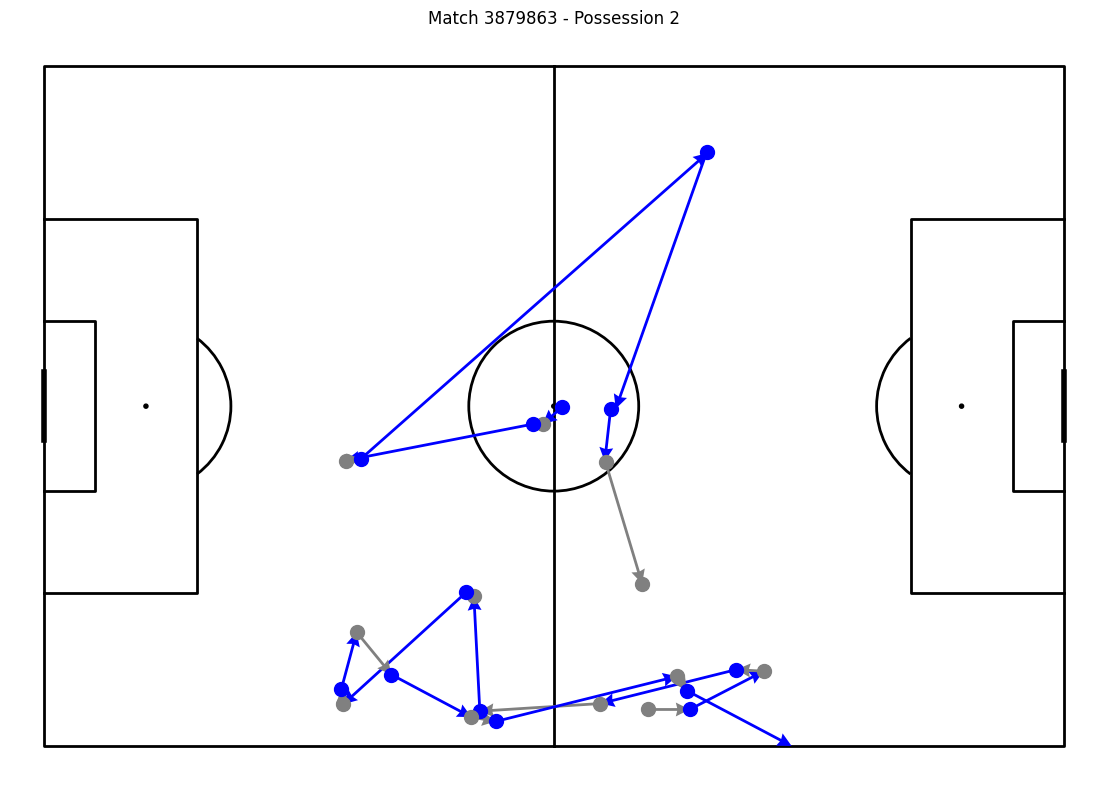

In [12]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# Filtruj po match_id i possession
match_id = 3879863  # twoje match_id
possession_num = 2
df_action = df_movement.filter(
    (df_movement.match_id == match_id) & (df_movement.possession == possession_num)
).orderBy('index').toPandas()

pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='white')
fig, ax = pitch.draw(figsize=(12, 8))

colors = {'Pass': 'blue', 'Carry': 'grey', 'Shot': 'red'}

for idx, row in df_action.iterrows():
    event_type = row['type']
    start = row['location']
    
    # Pobierz end_location
    end = None
    if event_type == 'Pass':
        end = row['pass_end_location']
    elif event_type == 'Carry':
        end = row['carry_end_location']
    
    # Sprawdź czy end istnieje (None sprawdza się normalnie)
    if end is None:
        continue
    
    # Strzałka
    pitch.arrows(start[0], start[1], end[0], end[1],
                 ax=ax, color=colors.get(event_type, 'gray'),
                 width=2, headwidth=5, headlength=5)
    
    # Punkt startowy
    pitch.scatter(start[0], start[1], ax=ax, 
                  color=colors.get(event_type, 'gray'), 
                  s=100, zorder=3)

# Shot marker
shots = df_action[df_action['type'] == 'Shot']
if not shots.empty:
    for _, shot in shots.iterrows():
        pitch.scatter(shot['location'][0], shot['location'][1],
                     ax=ax, color='red', s=300, 
                     marker='*', zorder=4)

plt.title(f'Match {match_id} - Possession {possession_num}')
plt.tight_layout()
plt.show()

In [13]:
# Policz długość każdej posesji
possession_lengths = df_movement.groupBy('match_id', 'possession').count()

# Statystyki
print("=== POSSESSION LENGTH STATISTICS ===")
possession_lengths.select('count').describe().show()

# Percentyle
print("\n=== PERCENTILES ===")
possession_lengths.selectExpr(
    "percentile_approx(count, 0.50) as p50_median",
    "percentile_approx(count, 0.75) as p75",
    "percentile_approx(count, 0.80) as p80",
    "percentile_approx(count, 0.90) as p90",
    "percentile_approx(count, 0.95) as p95",
    "percentile_approx(count, 0.99) as p99"
).show()

=== POSSESSION LENGTH STATISTICS ===
+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|            74190|
|   mean|8.956530529720986|
| stddev|9.127330187046526|
|    min|                1|
|    max|              143|
+-------+-----------------+


=== PERCENTILES ===
+----------+---+---+---+---+---+
|p50_median|p75|p80|p90|p95|p99|
+----------+---+---+---+---+---+
|         6| 12| 14| 20| 27| 43|
+----------+---+---+---+---+---+



In [14]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, desc, col

MAX_SEQUENCE_LENGTH = 12

# Define window: partition by possession, order by index DESCENDING (od końca!)
window_spec = Window.partitionBy('match_id', 'possession').orderBy(desc('index'))

# Numeruj eventy od końca (1 = ostatni event, 2 = przedostatni, etc.)
df_numbered = df_movement.withColumn(
    'event_rank',
    row_number().over(window_spec)
)

# Filtruj: zostaw tylko ostatnie 12 eventów
df_truncated = df_numbered.filter(col('event_rank') <= MAX_SEQUENCE_LENGTH)

print(f"\n=== TRUNCATION RESULTS ===")
print(f"Events before: {df_numbered.count():,}")
print(f"Events after: {df_truncated.count():,}")
print(f"Removed: {df_numbered.count() - df_truncated.count():,}")


=== TRUNCATION RESULTS ===
Events before: 664,485
Events after: 491,900
Removed: 172,585


In [15]:
df_truncated.show(20)

+--------+----------+-------+-----+-----+-------------+-----------------+------------------+------------+---------+---------------+----------+
|match_id|possession|   team|index| type|     location|pass_end_location|carry_end_location|shot_outcome|shot_type|possession_team|event_rank|
+--------+----------+-------+-----+-----+-------------+-----------------+------------------+------------+---------+---------------+----------+
| 3878540|         3|Bologna|   58| Shot| [93.1, 42.3]|             NULL|              NULL|       Off T|Open Play|        Bologna|         1|
| 3878540|         3|Bologna|   53| Shot|[104.5, 30.9]|             NULL|              NULL|     Blocked|Open Play|        Bologna|         2|
| 3878540|         3|Bologna|   51|Carry|[105.9, 27.2]|             NULL|     [104.5, 30.9]|        NULL|     NULL|        Bologna|         3|
| 3878540|         3|Bologna|   49| Pass|[111.6, 14.1]|    [105.9, 27.2]|              NULL|        NULL|     NULL|        Bologna|         4|

In [16]:
from pyspark.sql.functions import col, coalesce

# Ekstrakcja x, y z array[0] i array[1]
df_with_coords = df_truncated \
    .withColumn('x', col('location').getItem(0).cast('double')) \
    .withColumn('y', col('location').getItem(1).cast('double')) \
    .withColumn('end_x', coalesce(
        col('pass_end_location').getItem(0),
        col('carry_end_location').getItem(0)
    ).cast('double')) \
    .withColumn('end_y', coalesce(
        col('pass_end_location').getItem(1),
        col('carry_end_location').getItem(1)
    ).cast('double'))

df_with_coords.show(5)

+--------+----------+-------+-----+-----+-------------+-----------------+------------------+------------+---------+---------------+----------+-----+----+-----+-----+
|match_id|possession|   team|index| type|     location|pass_end_location|carry_end_location|shot_outcome|shot_type|possession_team|event_rank|    x|   y|end_x|end_y|
+--------+----------+-------+-----+-----+-------------+-----------------+------------------+------------+---------+---------------+----------+-----+----+-----+-----+
| 3878540|         3|Bologna|   58| Shot| [93.1, 42.3]|             NULL|              NULL|       Off T|Open Play|        Bologna|         1| 93.1|42.3| NULL| NULL|
| 3878540|         3|Bologna|   53| Shot|[104.5, 30.9]|             NULL|              NULL|     Blocked|Open Play|        Bologna|         2|104.5|30.9| NULL| NULL|
| 3878540|         3|Bologna|   51|Carry|[105.9, 27.2]|             NULL|     [104.5, 30.9]|        NULL|     NULL|        Bologna|         3|105.9|27.2|104.5| 30.9|
| 38

In [17]:
from pyspark.sql.functions import when,  struct, array, collect_list, col, lit

# Dodaj event_rank do structa
df_events = df_with_coords.withColumn(
    'is_goal',
    when(col('shot_outcome') == 'Goal', 1).otherwise(0).cast('int')
).withColumn(
    'event',
    struct(
        col('event_rank').alias('rank'),  # <-- dodane
        col('type').alias('type'),
        col('x').alias('x'),
        col('y').alias('y'),
        col('end_x').alias('end_x'),
        col('end_y').alias('end_y'),
        col('is_goal').alias('is_goal')
    )
)

# Agreguj
sequences = df_events.groupBy('match_id', 'possession', 'team').agg(
    collect_list('event').alias('events')
)

# Sortuj array po rank (DESC -> ASC, żeby było chronologicznie)
from pyspark.sql.functions import array_sort, expr

sequences = sequences.withColumn(
    'events',
    expr("array_sort(events, (left, right) -> case when left.rank < right.rank then 1 else -1 end)")
)

sequences.show(3, truncate=False)

+--------+----------+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|match_id|possession|team   |events                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
+---

In [18]:
df_with_coords.select("team", "type", "location","pass_end_location", "carry_end_location").filter((col('possession') == 4) & (col('match_id') == 3878540)).show(truncate=False)

+-------+-----+------------+-----------------+------------------+
|team   |type |location    |pass_end_location|carry_end_location|
+-------+-----+------------+-----------------+------------------+
|Bologna|Pass |[83.7, 59.8]|[73.5, 62.8]     |[NULL, NULL]      |
|Lazio  |Carry|[67.9, 62.5]|NULL             |[78.9, 59.5]      |
|Lazio  |Pass |[85.9, 54.2]|[67.9, 62.5]     |NULL              |
|Bologna|Carry|[95.3, 45.9]|[NULL, NULL]     |[86.8, 51.2]      |
|Lazio  |Carry|[92.0, 34.2]|NULL             |[94.4, 42.7]      |
|Lazio  |Pass |[94.2, 27.6]|[92.0, 34.2]     |NULL              |
|Lazio  |Carry|[96.5, 25.2]|NULL             |[94.2, 27.6]      |
|Lazio  |Pass |[90.3, 23.3]|[96.5, 25.2]     |NULL              |
|Lazio  |Carry|[76.9, 16.6]|NULL             |[90.3, 23.3]      |
|Lazio  |Pass |[72.8, 4.2] |[76.9, 16.6]     |NULL              |
|Lazio  |Carry|[72.4, 2.9] |NULL             |[72.8, 4.2]       |
|Bologna|Pass |[76.4, 16.5]|[78.6, 15.1]     |[NULL, NULL]      |
+-------+-

In [19]:
from pyspark.sql.functions import max as spark_max, size

# Najpierw zidentyfikuj czy posesja kończy się golem
sequences = sequences.withColumn(
    'goal',
    expr("aggregate(events, 0, (acc, x) -> acc + x.is_goal)").cast('int')
)

# Dodaj START na początek (przed pierwszym eventem)
# Użyj współrzędnych pierwszego eventu jako start location
sequences = sequences.withColumn(
    'start_event',
    struct(
        lit(999).alias('rank'),
        lit('START').alias('type'),
        lit(None).cast('double').alias('x'),  # NULL
        lit(None).cast('double').alias('y'),  # NULL
        expr("events[0].x").alias('end_x'),   # lokalizacja pierwszego eventu
        expr("events[0].y").alias('end_y'),
        lit(0).alias('is_goal')
    )
)

# Dodaj START do array
sequences = sequences.withColumn(
    'events',
    expr("concat(array(start_event), events)")
)

sequences.select('match_id', 'possession', 'team', 'goal', 'events').show(3, truncate=False)

+--------+----------+-------+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|match_id|possession|team   |goal|events                                                                                                                                                                                                                                                                                                                                                                                                                                

In [20]:
# Dodaj end token na koniec
sequences = sequences.withColumn(
    'end_event',
    struct(
        lit(0).alias('rank'),  # na początek przy sortowaniu
        when(col('goal') == 1, lit('GOAL')).otherwise(lit('NO_GOAL')).alias('type'),
        lit(None).cast('double').alias('x'),
        lit(None).cast('double').alias('y'),
        lit(None).cast('double').alias('end_x'),
        lit(None).cast('double').alias('end_y'),
        col('goal').alias('is_goal')
    )
)

sequences = sequences.withColumn(
    'events',
    expr("concat(events, array(end_event))")
)

# Dodaj sequence_length
sequences = sequences.withColumn(
    'sequence_length',
    size('events')
)

# Finalne kolumny
sequences_final = sequences.select(
    'match_id', 'possession', 'team', 'events', 'sequence_length', 'goal'
)

sequences_final.show(3, truncate=False)

+--------+----------+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+----+
|match_id|possession|team   |events                                                                                                                                                                                                                                                                                                                                                                            

In [21]:
print("=== STATISTICS ===")
sequences_final.select('sequence_length').describe().show()
sequences_final.groupBy('goal').count().show()
print(f"Total: {sequences_final.count():,}")

=== STATISTICS ===
+-------+------------------+
|summary|   sequence_length|
+-------+------------------+
|  count|             89490|
|   mean| 7.496703542295228|
| stddev|3.9239799960681285|
|    min|                 3|
|    max|                14|
+-------+------------------+

+----+-----+
|goal|count|
+----+-----+
|   1|  951|
|   0|88539|
+----+-----+

Total: 89,490


In [22]:
# Undersample do 5% goli
goals = sequences_final.filter(col('goal') == 1)
non_goals = sequences_final.filter(col('goal') == 0)

n_goals = goals.count()
sample_fraction = (n_goals / 0.05 - n_goals) / non_goals.count()

balanced = goals.union(non_goals.sample(fraction=sample_fraction, seed=42))

print(f"Total: {balanced.count():,}")
balanced.groupBy('goal').count().show()

Total: 19,019
+----+-----+
|goal|count|
+----+-----+
|   1|  951|
|   0|18068|
+----+-----+



In [23]:
# Usuń rank z eventów (nie potrzebny w finalnym zbiorze)
from pyspark.sql.functions import transform

balanced = balanced.withColumn(
    'events',
    transform(
        'events',
        lambda e: struct(
            e.type.alias('type'),
            e.end_x.alias('end_x'),
            e.end_y.alias('end_y')
        )
    )
)

# Konwertuj do pandas
df_pandas = balanced.toPandas()

# Zapisz
df_pandas.to_parquet('data/sequences_continuous_balanced.parquet', index=False)
print(f"✅ Saved {len(df_pandas):,} sequences")

✅ Saved 19,019 sequences


In [24]:
df = pd.read_parquet('data/sequences_continuous_balanced.parquet')
print(f"Loaded: {len(df):,} sequences")
print(f"Goals: {df['goal'].sum()} ({df['goal'].mean()*100:.1f}%)")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst sequence structure:")
print(df['events'].iloc[0])

Loaded: 19,019 sequences
Goals: 951 (5.0%)

Columns: ['match_id', 'possession', 'team', 'events', 'sequence_length', 'goal']

First sequence structure:
[{'end_x': 99.0, 'end_y': 74.4, 'type': 'START'}
 {'end_x': 92.9, 'end_y': 73.9, 'type': 'Carry'}
 {'end_x': 90.4, 'end_y': 55.2, 'type': 'Pass'}
 {'end_x': 90.4, 'end_y': 55.4, 'type': 'Carry'}
 {'end_x': 102.8, 'end_y': 54.8, 'type': 'Pass'}
 {'end_x': 67.0, 'end_y': 58.5, 'type': 'Pass'}
 {'end_x': 65.6, 'end_y': 59.3, 'type': 'Carry'}
 {'end_x': 75.6, 'end_y': 59.1, 'type': 'Pass'}
 {'end_x': 93.5, 'end_y': 65.2, 'type': 'Carry'}
 {'end_x': 107.8, 'end_y': 43.2, 'type': 'Pass'}
 {'end_x': 108.1, 'end_y': 41.0, 'type': 'Carry'}
 {'end_x': None, 'end_y': None, 'type': 'Shot'}
 {'end_x': None, 'end_y': None, 'type': 'GOAL'}]


In [25]:
# Tylko typy eventów
type_vocab = {
    'START': 0,
    'Pass': 1, 
    'Carry': 2,
    'Shot': 3,
    'GOAL': 4,
    'NO_GOAL': 5,
    '<pad>': 6
}

# Zapisz
with open('data/vocab_continuous.json', 'w') as f:
    json.dump(type_vocab, f, indent=2)

id_to_type = {v: k for k, v in type_vocab.items()}
with open('data/id_to_type_continuous.json', 'w') as f:
    json.dump(id_to_type, f, indent=2)

print(f"✅ Vocabulary size: {len(type_vocab)}")

✅ Vocabulary size: 7


In [26]:
# Sprawdź czy pliki istnieją:
import os

files_needed = [
    'data/sequences_continuous_balanced.parquet',
    'data/vocab_continuous.json',
    'data/id_to_type_continuous.json'
]

for f in files_needed:
    if os.path.exists(f):
        print(f"✅ {f}")
    else:
        print(f"❌ {f} - MISSING!")

✅ data/sequences_continuous_balanced.parquet
✅ data/vocab_continuous.json
✅ data/id_to_type_continuous.json
